# Glucose Data Analysis – Work Sample

**Author:** Pablo Solar

**Context:** Submitted for the Hello Inside application.

**Objective:** To demonstrate basic data processing, SQL handling, and visualization on a simulated dataset of glucose levels.

#### 1. Introduction

As a bioinformatician, my expertise is in genomic data processing, not glucose monitoring. However, with guidance from domain literature and ChatGPT-assisted research, I structured a realistic dataset and performed basic analysis to demonstrate how glucose levels fluctuate based on meals and exercise.

---
#### Step 1. Dataset Generation

This dataset simulates glucose measurements for 10 patients, recorded every 4 hours over 50 time points per patient. It includes:

- Patient ID
- Timestamp
- Glucose Level (mg/dL)
- Meal Type (Breakfast, Lunch, Dinner, No Meal)
- Exercise Level (No Exercise, Light, Moderate, Intense)

In [47]:
import pandas as pd
import numpy as np

# Define key parameters
num_patients = 10
num_measurements = 50  # Each patient will have 50 records
measurement_freq = "4h"  # Measurements every 4 hours

# Create patient identifiers
patient_ids = [f"P{str(i).zfill(3)}" for i in range(1, num_patients + 1)]

# Generate timestamps
timestamps = pd.date_range(start="2024-02-01", periods=num_measurements, freq=measurement_freq)

# Function to assign meals
def assign_meal(hour):
    conditions = [6 <= hour < 10, 12 <= hour < 15, 18 <= hour < 21]
    meals = ["Breakfast", "Lunch", "Dinner"]
    for condition, meal in zip(conditions, meals):
        if condition:
            return meal
    return "No meal"

# Generate data
data = []
for patient in patient_ids:
    for timestamp in timestamps:
        glucose_level = np.random.uniform(70, 180)
        meal = assign_meal(timestamp.hour)
        exercise = np.random.choice(["No Exercise", "Light", "Moderate", "Intense"],
                                    p=[0.5, 0.3, 0.15, 0.05])
        timestamp_str = timestamp.strftime("%Y-%m-%d %H:%M:%S")
        data.append([patient, timestamp_str, glucose_level, meal, exercise])

# Create DataFrame
df_glucose = pd.DataFrame(data, columns=["patient_id", "timestamp", "glucose_level", "meal", "exercise"])

# Display dataset sample
df_glucose.head()

,patient_id,timestamp,glucose_level,meal,exercise
0,P001,2024-02-01 00:00:00,159.251639,No meal,No Exercise
1,P001,2024-02-01 04:00:00,152.186789,No meal,Intense
2,P001,2024-02-01 08:00:00,150.860329,Breakfast,Light
3,P001,2024-02-01 12:00:00,117.018733,Lunch,No Exercise
4,P001,2024-02-01 16:00:00,127.851573,No meal,Moderate


---
#### Step 2: Storing Data in SQL

To ensure structured data storage, we use SQLite, defining a table with:

- A composite primary key _(patient_id, timestamp)_
    - Ensures uniqueness: Each patient can only have one glucose entry per timestamp.
    - Improves indexing: Queries are more efficient when filtering by patient or date.
- Columns for glucose levels, meal types, and exercise levels.


In [48]:
import sqlite3

# Create SQLite database (in-memory)
conn = sqlite3.connect(":memory:")
cursor = conn.cursor()

# Create table with composite primary key
cursor.execute('''
CREATE TABLE glucose (
    patient_id TEXT,
    timestamp TEXT,
    glucose_level REAL,
    meal TEXT,
    exercise TEXT,
    PRIMARY KEY (patient_id, timestamp)
)
''')

# Insert data
df_glucose.to_sql("glucose", conn, if_exists="append", index=False)

# Verify data insertion
cursor.execute("SELECT * FROM glucose LIMIT 5")
cursor.fetchall()

[('P001', '2024-02-01 00:00:00', 159.25163858535004, 'No meal', 'No Exercise'),
 ('P001', '2024-02-01 04:00:00', 152.18678934052724, 'No meal', 'Intense'),
 ('P001', '2024-02-01 08:00:00', 150.86032931658775, 'Breakfast', 'Light'),
 ('P001', '2024-02-01 12:00:00', 117.0187328384198, 'Lunch', 'No Exercise'),
 ('P001', '2024-02-01 16:00:00', 127.85157310504829, 'No meal', 'Moderate')]

---
#### Step 3: Data Analysis

We extract insights using SQL queries and extract some observations for each one:

#####Average glucose per meal type

In [57]:
query = '''
SELECT meal, AVG(glucose_level) as avg_glucose
FROM glucose
GROUP BY meal
'''
df_avg_glucose_meal = pd.read_sql(query, conn)
df_avg_glucose_meal

,meal,avg_glucose
0,Breakfast,127.805845
1,Dinner,119.793401
2,Lunch,121.382531
3,No meal,126.032341


Observations
- Breakfast has the highest glucose levels (127.81 mg/dL), which might be related to the body’s natural glucose regulation in the morning (e.g., the dawn phenomenon), but I do not have expertise in physiological mechanisms.
- Dinner (119.79 mg/dL) and Lunch (121.38 mg/dL) are relatively close, indicating that glucose levels might stabilize later in the day.
- No Meal (126.03 mg/dL) has a higher average glucose level than Lunch and Dinner, suggesting that fasting glucose regulation could be influencing these values.

_Note: While a trend is visible, a deeper analysis would require input from experts in glucose metabolism._

#####Highest glucose spikes (top 5)

In [58]:
query = '''
SELECT patient_id, timestamp, glucose_level
FROM glucose
ORDER BY glucose_level DESC
LIMIT 5
'''
df_highest_glucose_spikes = pd.read_sql(query, conn)
df_highest_glucose_spikes

,patient_id,timestamp,glucose_level
0,P006,2024-02-05 16:00:00,179.818661
1,P010,2024-02-09 00:00:00,179.397999
2,P002,2024-02-08 00:00:00,179.250407
3,P004,2024-02-06 08:00:00,179.238344
4,P005,2024-02-01 00:00:00,178.939089


Observations
- The highest glucose readings are close to 180 mg/dL, which is near the upper limit of the normal range for fasting glucose levels.
- These high readings are spread across different dates and times, suggesting no immediate time-based pattern.
- Since there is no clear meal pattern linked to these values, potential factors could include individual patient variability, stress, or other metabolic influences.

_Note: Without additional patient data (e.g., medical history, diet, or medications), interpreting why these readings occur is challenging._

#####Effect of exercise on glucose

In [59]:
query = '''
SELECT exercise, AVG(glucose_level) as avg_glucose
FROM glucose
GROUP BY exercise
'''
df_effect_exercise_glucose = pd.read_sql(query, conn)
df_effect_exercise_glucose

,exercise,avg_glucose
0,Intense,118.870140
1,Light,123.958365
2,Moderate,126.241145
3,No Exercise,125.120022


Observations
- Higher exercise intensity is associated with lower glucose levels:
  - Intense exercise (118.87 mg/dL) has the lowest glucose levels. This aligns with the expectation that physical activity helps lower blood sugar.
  - Light exercise (123.96 mg/dL) still shows a reduction, though not as much as intense activity.
- Moderate exercise (126.24 mg/dL) shows slightly higher glucose levels than no exercise (125.12 mg/dL).
  - This could be due to post-exercise glucose spikes, where the body releases glucose to compensate for energy use.
  - Alternatively, it might be due to individual variability in response to exercise.

_Note: These trends are interesting, but a medical expert could provide deeper insights into how different exercise intensities affect glucose metabolism._

##### Post-Meal Glucose Levels Based on Exercise

In [60]:
query = '''
SELECT
    meal,
    exercise,
    AVG(glucose_level) AS avg_glucose
FROM glucose
WHERE meal != 'No meal'  -- Focus only on cases where a meal was consumed
GROUP BY meal, exercise
ORDER BY meal, avg_glucose DESC;
'''
df_post_meal_glucose_exercise = pd.read_sql(query, conn)
df_post_meal_glucose_exercise

,meal,exercise,avg_glucose
0,Breakfast,Light,131.926803
1,Breakfast,No Exercise,128.173584
2,Breakfast,Moderate,124.314525
3,Breakfast,Intense,116.601180
4,Dinner,Light,123.850345
5,Dinner,No Exercise,120.306966
6,Dinner,Moderate,115.801373
7,Dinner,Intense,105.507192
8,Lunch,Moderate,144.064212
9,Lunch,Intense,127.330445


Observations

- Breakfast shows the highest glucose levels, especially after light exercise (131.93 mg/dL). Surprisingly, moderate exercise (124.31 mg/dL) has a slightly lower effect than expected. Intense exercise (116.60 mg/dL) shows the largest decrease, which suggests that higher intensity might help regulate glucose more effectively in the morning.

-	Lunch has the most unexpected results, with moderate exercise leading to the highest glucose level (144.06 mg/dL). This might mean that other factors, like the type of food eaten, are affecting glucose more than exercise itself.

- Dinner follows a clearer trend—glucose decreases as exercise intensity increases. With no exercise, levels are around 120.31 mg/dL, but with intense exercise, they drop significantly to 105.51 mg/dL.

- Overall, exercise tends to lower glucose, but the effect depends on the time of day and possibly the meal content.

_Note: These patterns give an interesting look at how glucose changes throughout the day, but a deeper analysis (e.g., tracking the time between eating and measuring glucose) would be needed for stronger conclusions_

---

#### Step 4: Data Visualization

We generate basic plots to analyze glucose variations


##### Average glucose per meal type

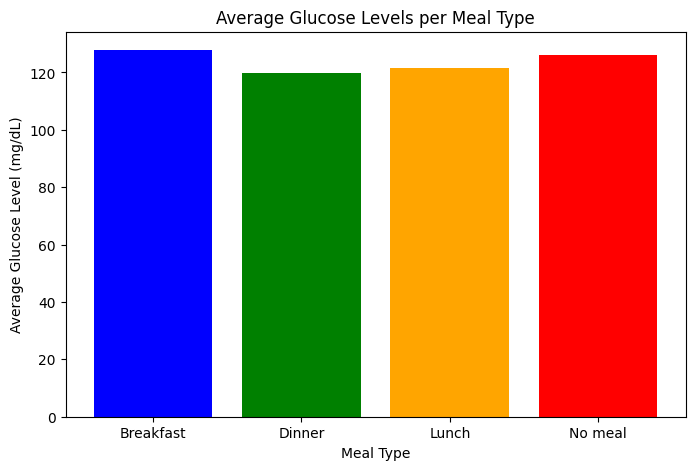

In [71]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(df_avg_glucose_meal["meal"], df_avg_glucose_meal["avg_glucose"], color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Meal Type")
plt.ylabel("Average Glucose Level (mg/dL)")
plt.title("Average Glucose Levels per Meal Type")
plt.show()

##### Highest glucose spikes (top 5)

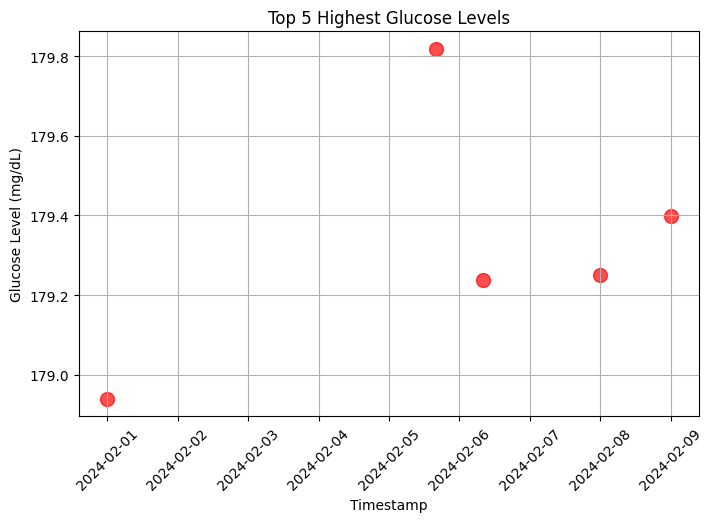

In [64]:
# Convert timestamp to datetime
df_highest_glucose_spikes["timestamp"] = pd.to_datetime(df_highest_glucose_spikes["timestamp"])

plt.figure(figsize=(8, 5))
plt.scatter(df_highest_glucose_spikes["timestamp"], df_highest_glucose_spikes["glucose_level"], c="red", s=100, alpha=0.7)
plt.xlabel("Timestamp")
plt.ylabel("Glucose Level (mg/dL)")
plt.title("Top 5 Highest Glucose Levels")
plt.xticks(rotation=45)
plt.grid()
plt.show()

##### Effect of exercise on glucose

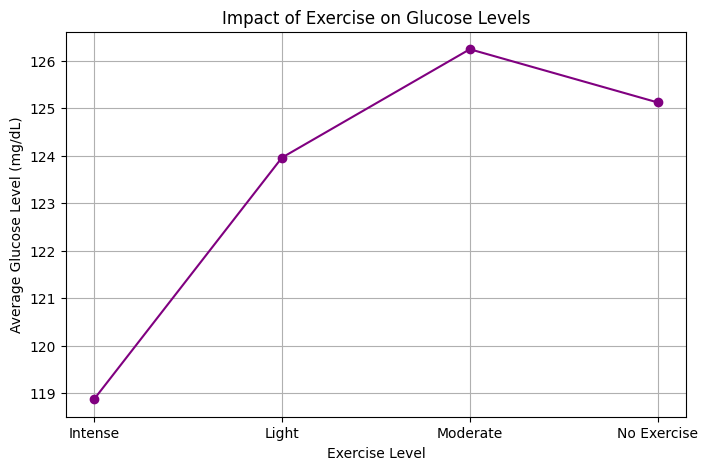

In [65]:
plt.figure(figsize=(8, 5))
plt.plot(df_effect_exercise_glucose["exercise"], df_effect_exercise_glucose["avg_glucose"], marker="o", linestyle="-", color="purple")
plt.xlabel("Exercise Level")
plt.ylabel("Average Glucose Level (mg/dL)")
plt.title("Impact of Exercise on Glucose Levels")
plt.grid()
plt.show()

##### Post-Meal Glucose Levels Based on Exercise

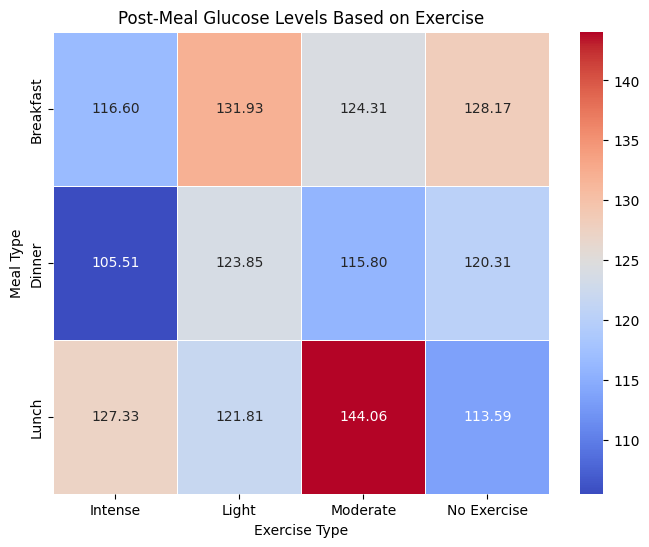

In [67]:
# Pivot for heatmap
heatmap_data = df_post_meal_glucose_exercise.pivot(index="meal", columns="exercise", values="avg_glucose")

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.xlabel("Exercise Type")
plt.ylabel("Meal Type")
plt.title("Post-Meal Glucose Levels Based on Exercise")
plt.show()

---

#### Final Observations & Conclusion

This work sample was created to demonstrate a structured approach to glucose data analysis, aligning with Hello Inside’s focus on personalized health insights. Given my background in bioinformatics, I aimed to apply data structuring, SQL queries, and visualization to explore glucose variations in relation to meals and exercise.

Key Takeaways:
- Meal & Glucose: Breakfast showed the highest glucose levels (~ 127.8 mg/dL), while dinner had the lowest (~119.8 mg/dL).

- Exercise & Glucose: Higher-intensity exercise generally correlated with lower glucose levels, especially after dinner (~105.5 mg/dL).

- Meal & Exercise Interaction: Some patterns, such as lunch paired with moderate exercise showing the highest glucose (~144 mg/dL), might require further context.

Since this is a synthetic dataset, the insights are purely exploratory and not clinically validated. I generated the dataset with the goal of applying bioinformatics and data analysis skills to a use case relevant to Hello Inside. This work sample serves as a demonstration of how I could contribute to data-driven insights in the context of glucose monitoring and metabolic health.